In [2]:
!pip install qiskit qiskit-aer
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector, entropy

  Using cached qiskit-2.2.3-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)
  Using cached qiskit_aer-0.17.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00


--- Simulating 12-Qubit Evaporation with Island ---
Step 1: B size = 11, R size = 1, S_vN = 0.9986 (std=0.9986, island=1.9964)
Step 2: B size = 10, R size = 2, S_vN = 1.9959 (std=1.9959, island=2.9879)
Step 3: B size = 9, R size = 3, S_vN = 2.9901 (std=2.9901, island=3.9538)
Step 4: B size = 8, R size = 4, S_vN = 3.9552 (std=3.9552, island=4.8190)
Step 5: B size = 7, R size = 5, S_vN = 4.8182 (std=4.8182, island=5.2696)
Step 6: B size = 6, R size = 6, S_vN = 4.8214 (std=5.2819, island=4.8214)
Step 7: B size = 5, R size = 7, S_vN = 3.9552 (std=4.8163, island=3.9552)
Step 8: B size = 4, R size = 8, S_vN = 2.9917 (std=3.9564, island=2.9917)
Step 9: B size = 3, R size = 9, S_vN = 1.9986 (std=2.9906, island=1.9986)
Step 10: B size = 2, R size = 10, S_vN = 0.9999 (std=1.9989, island=0.9999)
Step 11: B size = 1, R size = 11, S_vN = 0.0000 (std=1.0000, island=0.0000)


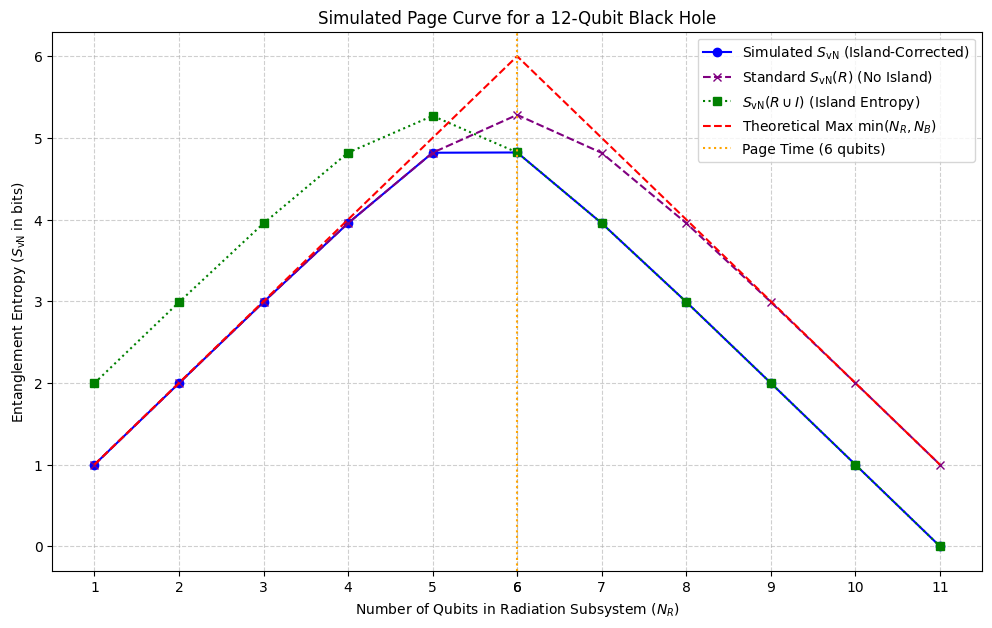

In [3]:
# --- 0. Imports & Options ---
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector, entropy


# --- 1. System Definition Parameters ---
N_QUBITS = 12
B_INITIAL_SIZE = N_QUBITS
R_INITIAL_SIZE = 0


# --- 2. Evaporation Operation (Unitary) ---
def get_scrambling_unitary(b_qubits_indices, num_total_qubits):
    """
    Creates a more complex entangling unitary gate across the current black hole
    qubits to model entanglement and scrambling. Increased complexity.
    """
    qc = QuantumCircuit(num_total_qubits)
    # Apply multiple layers of diverse entangling gates and local rotations for more scrambling
    for _ in range(15):  # Keeping layers at 15 but increasing complexity per layer
        # Apply a mix of CNOT, CZ, and CY gates in different patterns
        if len(b_qubits_indices) > 1:
            for i in range(len(b_qubits_indices) - 1):
                qc.cx(b_qubits_indices[i], b_qubits_indices[i + 1])
                qc.cz(b_qubits_indices[i], b_qubits_indices[i + 1])
                qc.cy(b_qubits_indices[i + 1], b_qubits_indices[i])  # Varying target/control
                qc.swap(b_qubits_indices[i], b_qubits_indices[i + 1])  # Add SWAP gates

        # Apply local rotations with varying angles
        for qubit_index in b_qubits_indices:
            qc.rz(np.random.rand() * 2 * np.pi, qubit_index)
            qc.ry(np.random.rand() * 2 * np.pi, qubit_index)
            qc.rx(np.random.rand() * 2 * np.pi, qubit_index)

        # Add global entangling gates between more distant qubits
        if len(b_qubits_indices) > 3:
            # Example: CNOT between the first and last, and second and second-to-last
            qc.cx(b_qubits_indices[0], b_qubits_indices[-1])
            qc.cy(b_qubits_indices[1], b_qubits_indices[-2])
            qc.cz(b_qubits_indices[0], b_qubits_indices[-2])  # More complex long-range interaction

    # We return the whole circuit compositionally for simplicity in Colab
    return qc


def initialize_system(n_qubits):
    """
    Initializes the total system in a pure state (|00...0>).
    """
    qc = QuantumCircuit(n_qubits)
    # All qubits start in the pure state |0>
    return qc


# --- Echo coupling helper ---
def apply_echo_coupling(qc, r_qubits, b_qubits, p_echo=0.5):
    """
    Applies a single echo pulse between an old radiation qubit and a black-hole interior qubit.
    - p_echo: probability of applying the echo on a given step (0..1).
    This function mutates qc in-place and returns it.
    """
    if len(r_qubits) == 0 or len(b_qubits) == 0:
        return qc

    # Probabilistic trigger
    if np.random.rand() > p_echo:
        return qc

    # Choose targets: oldest radiation and most recent interior
    r_target = r_qubits[0]
    b_target = b_qubits[-1]

    # Echo pulse: bidirectional feedback gates (small pulse)
    qc.cx(r_target, b_target)   # r -> b
    qc.cz(b_target, r_target)   # b -> r (phase)
    qc.cy(r_target, b_target)   # r -> b (y)
    # small random rotations to create chaotic feedback
    qc.rx(np.random.rand() * 2 * np.pi, r_target)
    qc.ry(np.random.rand() * 2 * np.pi, b_target)

    return qc


def simulate_evaporation(initial_qc, n_total, echo_after_page=True, p_echo=0.5):
    """
    Simulates the black hole evaporation process step-by-step and calculates
    the entanglement entropy of the radiation (R) subsystem, applying the
    Island Mechanism after Page Time. Also applies echo coupling *after* emission,
    optionally only after Page time.
    """

    current_circuit = initial_qc.copy()

    # Track results
    entanglement_entropies = []
    s_standard_list = []
    s_island_list = []

    page_time = n_total // 2  # integer page time (important)

    # Start with all qubits in B (Black Hole), R is empty
    b_qubits = list(range(n_total))  # Qubit indices currently in B
    r_qubits = []                    # Qubit indices currently in R

    print(f"--- Simulating {n_total}-Qubit Evaporation with Island ---")

    # Loop through the evaporation process (emitting one qubit at a time)
    # Stop when the black hole has only one qubit left.
    step_count = 0
    while len(b_qubits) > 1:
        step_count += 1

        # --- Evaporation Step ---
        qubit_to_emit = b_qubits[0]

        # 1) Scramble B (internal scrambling only)
        scrambler_qc = get_scrambling_unitary(b_qubits, n_total)
        current_circuit.compose(scrambler_qc, inplace=True)

        # 2) (Optional) After Page Time: entangle outgoing qubit with old radiation (information transfer)
        # Note: condition uses len(r_qubits) >= page_time so echo can be meaningful later
        if len(r_qubits) >= page_time and len(r_qubits) > 0:
            oldest_r_qubit = r_qubits[0]
            current_circuit.cx(qubit_to_emit, oldest_r_qubit)

            if len(r_qubits) > 1:
                second_oldest_r_qubit = r_qubits[1]
                current_circuit.cz(qubit_to_emit, second_oldest_r_qubit)

        # 3) Emit: Now move the qubit from B to R (bookkeeping only)
        qubit_to_emit = b_qubits.pop(0)
        r_qubits.append(qubit_to_emit)

        # 4) Echo coupling: apply AFTER emission (correct causal placement)
        # If echo_after_page=True we only allow echo when len(r_qubits) > page_time
        if echo_after_page:
            if len(r_qubits) > page_time:
                current_circuit = apply_echo_coupling(current_circuit, r_qubits, b_qubits, p_echo=p_echo)
        else:
            # allow echo at any time probabilistically
            current_circuit = apply_echo_coupling(current_circuit, r_qubits, b_qubits, p_echo=p_echo)

        # --- Entanglement Calculation (Island-corrected) ---
        # 5) Compute the current quantum state vector
        state_vector = Statevector.from_instruction(current_circuit)

        # --- FIRST ENTROPY: Standard S_vN(R) ---
        # Keep r_qubits to get rho_R (reduced density of radiation)
        # Qiskit's partial_trace takes the indices of qubits to be TRACED OUT
        # So, to get rho_R, trace out b_qubits.
        if len(b_qubits) > 0:
            rho_R = partial_trace(state_vector, b_qubits)
            s_vn_standard = entropy(rho_R, base=2)
        else: # if B is empty, R is the whole system, and s_vn_standard should be 0
            s_vn_standard = 0.0 # pure state


        # --- SECOND ENTROPY: S_vN(R U I) (Island) ---
        s_vn_island = None
        if len(b_qubits) > 0: # An island can only exist if there's still a black hole
            island_qubit = b_qubits[-1]  # define island as last remaining qubit in B

            # We want the entropy of R U I. So, trace out (B \ I)
            # The qubits to trace out are all qubits in B EXCEPT the island_qubit
            qubits_to_trace_out_for_island = [q for q in b_qubits if q != island_qubit]

            if len(qubits_to_trace_out_for_island) > 0:
                rho_island_corrected = partial_trace(state_vector, qubits_to_trace_out_for_island)
                s_vn_island = entropy(rho_island_corrected, base=2)
            else:
                # If B only contains the island, then R U I is the entire system. Trace nothing out.
                # In this case, rho_island_corrected is the full state, and its entropy is 0.
                s_vn_island = 0.0

            # The final entanglement entropy is the minimum of the two cases (island rule)
            s_vn = min(s_vn_standard, s_vn_island)
        else:
            # If B is empty, the only choice is the standard S_vN(R) (which will be 0 as R is the whole pure system)
            s_vn = s_vn_standard
            s_vn_island = 0.0 # R U I is just R, and R is pure.


        entanglement_entropies.append(s_vn)
        s_standard_list.append(s_vn_standard)
        s_island_list.append(s_vn_island)

        print(f"Step {len(r_qubits)}: B size = {len(b_qubits)}, R size = {len(r_qubits)}, "
              f"S_vN = {s_vn:.4f} (std={s_vn_standard:.4f}, island={('N/A' if s_vn_island is None else f'{s_vn_island:.4f}')})")

    # returns page-curve data plus diagnostics
    return {
        's_min_curve': entanglement_entropies,
        's_standard': s_standard_list,
        's_island': s_island_list
    }


def plot_page_curve(data_dict, n_total):
    """
    Plots the simulated Page Curve, svnR, svnB, and the theoretical S_min bound.
    Accepts the dictionary returned by simulate_evaporation.
    Generates a single plot with all curves.
    """
    s_min_curve = data_dict["s_min_curve"]
    s_std = data_dict["s_standard"]
    s_isl = data_dict["s_island"]

    num_steps = len(s_min_curve)

    # 1. X-Axis: Number of qubits in the radiation (N_R)
    r_qubit_count = list(range(1, num_steps + 1))

    # 2. Theoretical Page Curve Limit (S_min)
    theoretical_limit = []
    for n_r in r_qubit_count:
        n_b = n_total - n_r
        S_min = min(n_r, n_b)
        theoretical_limit.append(S_min)

    # Page Time Marker (integer)
    page_time = n_total // 2

    # --- Single Plot with all curves ---
    plt.figure(figsize=(12, 7))

    # Simulated Entanglement Entropy (S_vN) - Island Corrected
    plt.plot(r_qubit_count, s_min_curve, label=r'Simulated $S_{\mathrm{vN}}$ (Island-Corrected)',
             marker='o', linestyle='-', color='blue')

    # S_vN(R) - Standard Radiation Entropy
    plt.plot(r_qubit_count, s_std, label=r'Standard $S_{\mathrm{vN}}(R)$ (No Island)',
             marker='x', linestyle='--', color='purple')

    # S_vN(R U I) - Island Entropy
    s_isl_plot = [v if v is not None else np.nan for v in s_isl] # Handle None values for plotting
    plt.plot(r_qubit_count, s_isl_plot, label=r'$S_{\mathrm{vN}}(R \cup I)$ (Island Entropy)',
             marker='s', linestyle=':', color='green')

    # Theoretical Bound
    plt.plot(r_qubit_count, theoretical_limit, label=r'Theoretical Max $\min(N_R, N_B)$',
             linestyle='--', color='red')

    # Page Time Marker
    plt.axvline(x=page_time, color='orange', linestyle=':',
                label=f'Page Time ({page_time} qubits)')

    # Aesthetics
    plt.title(f'Simulated Page Curve for a {n_total}-Qubit Black Hole')
    plt.xlabel('Number of Qubits in Radiation Subsystem ($N_R$)')
    plt.ylabel(r'Entanglement Entropy ($S_{\mathrm{vN}}$ in bits)')
    plt.xticks(list(range(1, num_steps + 1)) + [page_time])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()


# --- Execution ---
initial_circuit = initialize_system(N_QUBITS)
results = simulate_evaporation(initial_circuit, N_QUBITS, echo_after_page=True, p_echo=0.6)

plot_page_curve(results, N_QUBITS)
